In [1]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import plotters as pt
import os 
import pickle
import numpy as np
import transformers as tf



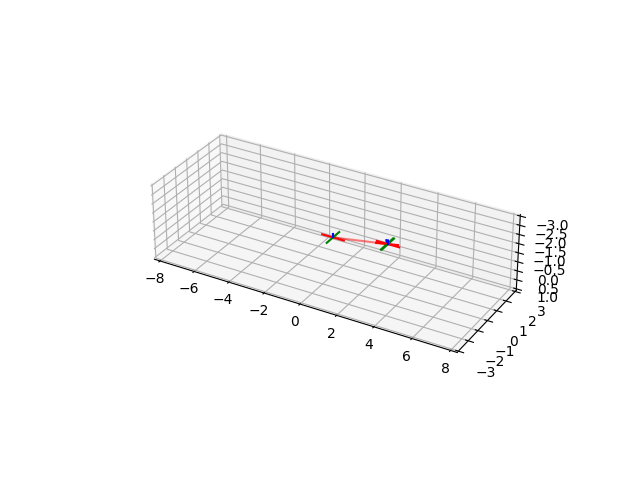

In [3]:
data_path = os.path.join("data","ascend"+".pkl")

# Load Flight Data
with open(data_path,'rb') as file:
    idl_data = pickle.load(file)

Ti:np.ndarray   = idl_data['Ti']
FOi:np.ndarray  = idl_data['FOi']
tXUi:np.ndarray = idl_data['tXUi']
Ci:np.ndarray   = idl_data['Ci']

pt.tXU_to_3D([tXUi])

In [4]:
print("Ti (first 5 entries):", Ti[:5])
print("FOi (first 5 entries):", FOi[:5])
print("tXUi (first 5 entries):", tXUi[:5])
print("Ci (first 5 entries):", Ci[:5])


Ti (first 5 entries): [0.    0.005 0.01  0.015 0.02 ]
FOi (first 5 entries): [[[-7.85304432e-08 -1.10725772e-07 -3.37095344e-08 -1.50306686e-07
    3.10459506e+01 -1.23494508e+02  2.00253226e+02 -1.03822200e+02
   -1.11992149e+02  2.42301746e+02 -3.19639958e+02  1.96666868e+02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [-9.99691994e-01  2.87610334e-08  3.06035762e-09  1.52245551e-08
   -5.17432508e+00  2.05824180e+01 -3.33755376e+01  1.73037003e+01
    1.86653572e+01 -4.03836226e+01  5.32733241e+01 -3.27778099e+01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[-7.82792199e-08  5.32683648e-07  3.85472331e-04  1.53690091e-01
    3.04309791e+01 -1.22494542e+02  1.99732720

In [5]:
# Extract x position data from FOi
x_positions_FOi = FOi[:, 0, 0]

# Prepare dataset for supervised learning
X_FOi = x_positions_FOi#[:-1]  # Current x positions
y_FOi = x_positions_FOi#[1:]   # Next x positions

# Manually split the dataset into training, validation, and test sets
# Shuffle the dataset indices
indices_FOi = np.arange(X_FOi.shape[0])
np.random.shuffle(indices_FOi)

# Determine split sizes based on the corrected dataset size
train_size_FOi = int(0.8 * len(indices_FOi))  # 80% for training
val_size_FOi = int(0.1 * len(indices_FOi))    # 10% for validation
test_size_FOi = len(indices_FOi) - train_size_FOi - val_size_FOi  # The remaining 10% for testing

# Split the dataset indices
train_indices_FOi = indices_FOi[:train_size_FOi]
val_indices_FOi = indices_FOi[train_size_FOi:train_size_FOi + val_size_FOi]
test_indices_FOi = indices_FOi[train_size_FOi + val_size_FOi:]

# Extract the dataset splits using the indices
X_train_FOi = X_FOi[train_indices_FOi]
y_train_FOi = y_FOi[train_indices_FOi]

X_val_FOi = X_FOi[val_indices_FOi]
y_val_FOi = y_FOi[val_indices_FOi]

X_test_FOi = X_FOi[test_indices_FOi]
y_test_FOi = y_FOi[test_indices_FOi]

# Output the shapes of the splits to confirm the process
X_train_FOi.shape, X_val_FOi.shape, X_test_FOi.shape,y_train_FOi.shape, y_val_FOi.shape, y_test_FOi.shape

((480,), (60,), (61,), (480,), (60,), (61,))

In [6]:
print(X_train_FOi)

[ 1.56761936e-01  3.52441322e-03  2.27954460e+00  2.92536498e+00
  7.83874093e-01  2.96002045e+00  1.17498767e+00  2.64055993e+00
  2.73328558e+00  1.30366578e+00  2.66098478e-01  2.94453395e+00
  2.06161105e+00  3.28150084e-01  2.99511634e+00  2.86448983e+00
  2.99446087e+00  1.60619915e-01  2.98622551e+00  1.68513959e-01
  2.81005819e+00  2.99292797e+00  2.53923277e+00  3.10475940e-01
  1.18560957e+00  4.18023424e-01  4.60213246e-01  3.48526272e-02
  2.97336252e+00  6.07708025e-01  2.44849179e+00  2.99622751e+00
  2.99745934e+00  2.98758867e+00  4.43485389e-03  9.24104722e-03
  2.95847026e+00  9.98241281e-01  3.25348926e-03  9.43569663e-02
  2.90495978e+00  1.44378339e-03  2.08142257e+00  1.24665544e-01
  2.19698564e+00  5.89725707e-03  4.11454880e-03  6.24407149e-01
  2.99913432e+00  2.90769170e+00  5.04549936e-01  5.03334223e-06
  6.28100190e-02  1.32532730e+00  3.81125150e-03  1.57630908e+00
  2.99777062e+00  2.84258183e+00  1.22945690e-07  1.85020611e-01
  2.10108427e+00  1.02876

In [23]:
import numpy as np

def normalize_data(data, feature_range=(0, 1)):
    """
    Normalize data to a specified range.

    Parameters:
    - data: Data to be normalized (numpy array).
    - feature_range: Tuple (min, max) specifying the range of the normalized data.

    Returns:
    - normalized_data: Normalized data.
    """
    min_val, max_val = feature_range
    data_min = np.min(data)
    data_max = np.max(data)
    # Scale data to [0,1]
    normalized_data = (data - data_min) / (data_max - data_min)
    # Scale data to feature_range
    normalized_data = normalized_data * (max_val - min_val) + min_val
    return normalized_data

# Assuming X_data and Y_data are your data arrays
# Normalize X_data and Y_data
Xtr_data_normalized = X_train_FOi#normalize_data(np.array(X_train_FOi))
Ytr_data_normalized = y_train_FOi#normalize_data(np.array(y_train_FOi))
Xv_data_normalized = X_val_FOi#normalize_data(np.array(X_val_FOi))
Yv_data_normalized = y_val_FOi#normalize_data(np.array(y_val_FOi))
Xte_data_normalized = X_test_FOi#normalize_data(np.array(X_test_FOi))
Yte_data_normalized = y_test_FOi#normalize_data(np.array(y_test_FOi))
# Use distinct token values
# SOS_token = 2  # Assuming normalized data in [0, 1]
# EOS_token = 3   # Assuming normalized data in [0, 1]

# Then proceed with your segmentation or other processing steps


In [8]:
# import numpy as np

# def segment_data(X, Y, length=8, SOS_token=2, EOS_token=3):
#     """
#     Segments the given X and Y arrays into sequences of the specified length,
#     including SOS and EOS tokens at the beginning and end of each sequence.
#     Each sequence overlaps with the next, where the last element of one sequence
#     is the first element of the next.

#     Parameters:
#     - X: Input data array
#     - Y: Target data array
#     - length: The length of each segmented sequence (default: 8)
#     - SOS_token: Start of sequence token (default: 2) -this token should change it's value it could mess data
#     - EOS_token: End of sequence token (default: 3) -this token should change it's value it could mess data

#     Returns:
#     - A list of segmented data pairs [segmented_X, segmented_Y] with SOS and EOS tokens
#     """
#     data = []
#     X = np.array(X)
#     Y = np.array(Y)

#     for i in range(len(X) - length + 1):
#         X_segment = X[i:i + length]
#         Y_segment = Y[i:i + length]
        
#         # Print original segments before adding tokens
#         print(f'Original X_segment[{i}]: {X_segment}')
#         print(f'Original Y_segment[{i}]: {Y_segment}')
        
#         # Insert SOS at the beginning and EOS at the end of each segment
#         X_segment = np.insert(X_segment, 0, SOS_token)
#         Y_segment = np.insert(Y_segment, 0, SOS_token)
#         X_segment = np.append(X_segment, EOS_token)
#         Y_segment = np.append(Y_segment, EOS_token)
        
#         # Print segments after adding tokens
#         print(f'With Tokens X_segment[{i}]: {X_segment}')
#         print(f'With Tokens Y_segment[{i}]: {Y_segment}')

#         data.append([X_segment, Y_segment])

#     np.random.shuffle(data)
#     return data




In [24]:
import numpy as np

def segment_data(X, Y, length=8):
    """
    Segments the given X and Y arrays into sequences of the specified length.
    Each sequence overlaps with the next, where the last element of one sequence
    is the first element of the next.

    Parameters:
    - X: Input data array
    - Y: Target data array
    - length: The length of each segmented sequence (default: 8)

    Returns:
    - A list of segmented data pairs [segmented_X, segmented_Y]
    """
    data = []
    
    # Ensure X and Y are numpy arrays for consistency in processing
    X = np.array(X)
    Y = np.array(Y)

    # Segment the data
    num_segments = len(X) - length + 1  # Calculate the number of segments
    for i in range(num_segments):
        X_segment = X[i:i + length]
        Y_segment = Y[i:i + length]
        data.append([X_segment, Y_segment])

    # Optionally, shuffle the segmented data pairs to randomize the order
    np.random.shuffle(data)

    return data

# # Example usage:
# X_data = X_train_FOi
# Y_data = y_train_FOi

# train_segmented_data = segment_data(X_data, Y_data, length=8)
# for pair in train_segmented_data:
#     print(f'X: {pair[0]}, Y: {pair[1]}')


In [25]:
# Example usage with your data:
X_data = Xtr_data_normalized #X_train_FOi  # Your X_train data here
Y_data = Ytr_data_normalized #y_train_FOi # Your Y_train data here

train_segmented_data = segment_data(X_data, Y_data, length=8)
for pair in train_segmented_data[:5]:  # Print the first 5 pairs to check
    print(f'X: {pair[0]}, Y: {pair[1]}')

X: [2.61488654 0.06072785 0.88869089 0.43184529 0.01963131 2.97767701
 2.99541829 2.57453146], Y: [2.61488654 0.06072785 0.88869089 0.43184529 0.01963131 2.97767701
 2.99541829 2.57453146]
X: [0.32219619 2.60831387 0.01528393 2.93436169 1.4998021  0.08894308
 0.06711707 2.9229927 ], Y: [0.32219619 2.60831387 0.01528393 2.93436169 1.4998021  0.08894308
 0.06711707 2.9229927 ]
X: [2.99710111e+00 7.74605505e-01 2.91809736e+00 1.58922471e-05
 2.59498426e+00 2.40004533e+00 2.98475304e+00 2.16244923e-01], Y: [2.99710111e+00 7.74605505e-01 2.91809736e+00 1.58922471e-05
 2.59498426e+00 2.40004533e+00 2.98475304e+00 2.16244923e-01]
X: [0.04404265 1.93986556 1.1327211  0.59122477 0.09714321 1.68510862
 0.01040219 2.99898741], Y: [0.04404265 1.93986556 1.1327211  0.59122477 0.09714321 1.68510862
 0.01040219 2.99898741]
X: [9.43569663e-02 2.90495978e+00 1.44378339e-03 2.08142257e+00
 1.24665544e-01 2.19698564e+00 5.89725707e-03 4.11454880e-03], Y: [9.43569663e-02 2.90495978e+00 1.44378339e-03 2.08

In [26]:
val_segmented_data = segment_data(Xv_data_normalized, Yv_data_normalized, length=8)

In [27]:
test_segmented_data = segment_data(Xte_data_normalized, Yte_data_normalized, length=8)

In [28]:
import numpy as np

def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # We make sure we dont get the last bit if its not batch_size size
        if idx + batch_size < len(data):
            # Here you would need to get the max length of the batch,
            # and normalize the length with the PAD token.
            if padding:
                max_batch_length = 0

                # Get longest sentence in batch
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # Append X padding tokens until it reaches the max length
                for seq_idx in range(batch_size):
                    remaining_length = max_batch_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches


In [29]:
#set the batchify 
train_dataloader = batchify_data(train_segmented_data, batch_size=16, padding=True)
val_dataloader = batchify_data(val_segmented_data, batch_size=16, padding=True)
test_dataloader = batchify_data(test_segmented_data, batch_size=16, padding=True)

29 batches of size 16
3 batches of size 16
3 batches of size 16


In [30]:
print(f"Train batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

# If batches are not empty, check the shape of the first batch
if train_dataloader:
    print(f"First train batch shape: {train_dataloader[0].shape}")
if val_dataloader:
    print(f"First validation batch shape: {val_dataloader[0].shape}")
if test_dataloader:
    print(f"First test batch shape: {test_dataloader[0].shape}")


Train batches: 29
Validation batches: 3
Test batches: 3
First train batch shape: (16, 2, 8)
First validation batch shape: (16, 2, 8)
First test batch shape: (16, 2, 8)


In [31]:
def train_loop(model, opt, loss_fn, dataloader): #implement teacher forcing
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        print(X.shape, y_input.shape, y_expected.shape)
        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

def validation_loop(model, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)


def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list, validation_loss_list

In [32]:
model = tf.Transformer(
    num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1
)

/home/aditipat/anaconda3/envs/sfti-env/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [33]:
train_loss_list, validation_loss_list = tf.fit(model, train_dataloader, val_dataloader, 10)

Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 1.1317
Validation loss: 1.1989

------------------------- Epoch 2 -------------------------
Training loss: 1.0633
Validation loss: 1.1601

------------------------- Epoch 3 -------------------------
Training loss: 1.0479
Validation loss: 1.1338

------------------------- Epoch 4 -------------------------
Training loss: 1.0323
Validation loss: 1.1118

------------------------- Epoch 5 -------------------------
Training loss: 1.0246
Validation loss: 1.0964

------------------------- Epoch 6 -------------------------
Training loss: 1.0089
Validation loss: 1.0787

------------------------- Epoch 7 -------------------------
Training loss: 0.9994
Validation loss: 1.0679

------------------------- Epoch 8 -------------------------
Training loss: 0.9959
Validation loss: 1.0556

------------------------- Epoch 9 -------------------------
Training loss: 0.9886
Validation loss: 1.0509

-------

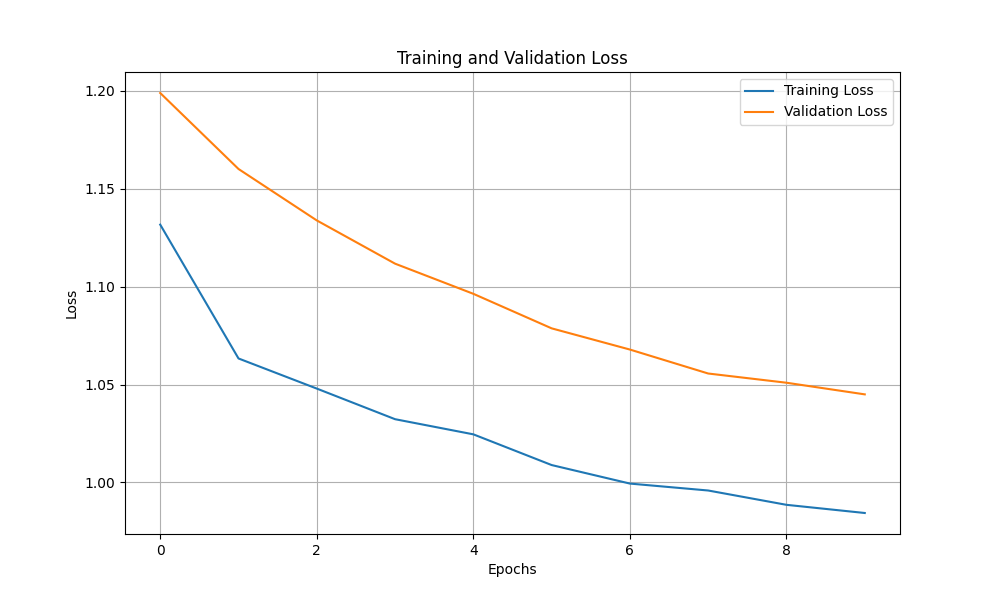

In [34]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
import torch
# Fetch one batch from the test_dataloader
for batch in test_dataloader:
    print(f"Batch structure: {type(batch)}")
    if isinstance(batch, (list, tuple)):
        print(f"Number of elements in the batch: {len(batch)}")
    # Optionally, print the shapes or types of the first few elements to understand their structure
    for i, item in enumerate(batch):
        if torch.is_tensor(item):
            print(f"Element {i} shape: {item.shape}")
        else:
            print(f"Element {i} is a {type(item)}")
    break  # Only inspect the first batch


Batch structure: <class 'numpy.ndarray'>
Element 0 is a <class 'numpy.ndarray'>
Element 1 is a <class 'numpy.ndarray'>
Element 2 is a <class 'numpy.ndarray'>
Element 3 is a <class 'numpy.ndarray'>
Element 4 is a <class 'numpy.ndarray'>
Element 5 is a <class 'numpy.ndarray'>
Element 6 is a <class 'numpy.ndarray'>
Element 7 is a <class 'numpy.ndarray'>
Element 8 is a <class 'numpy.ndarray'>
Element 9 is a <class 'numpy.ndarray'>
Element 10 is a <class 'numpy.ndarray'>
Element 11 is a <class 'numpy.ndarray'>
Element 12 is a <class 'numpy.ndarray'>
Element 13 is a <class 'numpy.ndarray'>
Element 14 is a <class 'numpy.ndarray'>
Element 15 is a <class 'numpy.ndarray'>


In [36]:
def unnormalize_data(normalized_data, original_min, original_max, feature_range=(0, 1)):
    """
    Unnormalize data back to its original scale.
    
    Parameters:
    - normalized_data: The data to be unnormalized.
    - original_min: The minimum value of the original data before normalization.
    - original_max: The maximum value of the original data before normalization.
    - feature_range: The range to which the data was normalized.
    
    Returns:
    - unnormalized_data: Data converted back to its original scale.
    """
    min_val, max_val = feature_range
    # Reverse the scaling
    scaled_data = (normalized_data - min_val) / (max_val - min_val)
    # Reverse the normalization
    unnormalized_data = scaled_data * (original_max - original_min) + original_min
    return unnormalized_data


In [44]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

#2 and 3 are the start and end token
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = tf.predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()




Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 5
Input: [0, 1]
Continuation: [0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2]

